In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from os.path import isfile
from datetime import datetime
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


## Load training and Validation arrays

In [3]:
#dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}
dict_genres = {'Folk':2, 'Instrumental':4, 'Pop':6, 'Rock' :7}

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{2: 'Folk', 4: 'Instrumental', 6: 'Pop', 7: 'Rock'}


In [4]:
npzfile = np.load('data/shuffled_train.npz')
print(npzfile.files)

X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [5]:
y_train_mask = np.in1d(y_train, list(dict_genres.values()))

In [6]:
y_train = y_train[y_train_mask]

In [7]:
y_train = utils.to_categorical(y_train, num_classes=8).astype(int)

In [8]:
X_train = X_train[y_train_mask]

In [9]:
X_train.shape, y_train.shape

((3199, 640, 128), (3199, 8))

In [10]:
npzfile = np.load('data/shuffled_valid.npz')
print(npzfile.files)

X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [11]:
y_valid_mask = np.in1d(y_valid, list(dict_genres.values()))

In [12]:
y_valid = y_valid[y_valid_mask]

In [13]:
y_valid = utils.to_categorical(y_valid, num_classes=8).astype(int)

In [14]:
X_valid = X_valid[y_valid_mask]

In [15]:
X_valid.shape, y_valid.shape

((400, 640, 128), (400, 8))

## Check by plotting a Spectogram

Pop


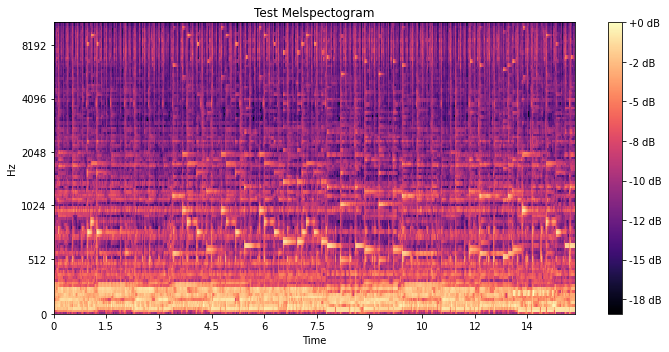

In [16]:
num = 0
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

## Parallel CNN - RNN Model

In [17]:
batch_size = 32
num_classes = 2
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [18]:
nb_filters1=32
nb_filters2=64
nb_filters3=128
nb_filters4=512
ksize = (3,3)
pool_size_1= (2,2)

BATCH_SIZE = 64
EPOCH_COUNT = 30

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_1)(conv_4)
    
    flatten1 = Flatten()(pool_4)
    
    output = Dense(num_classes, activation = 'softmax', name='preds')(flatten1)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [19]:
def train_model(x_train, y_train, x_val, y_val, info = "", genres_name = ""):
    n_frames = 640
    n_frequency = 128
    
    #reshape and expand dims for conv2d
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    log_dir = ".\\logs\\model_root_f1\\"+datetime.now().strftime("%Y%m%d-%H%M%S_")+info
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False, update_freq='batch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None)

    model_folder = "./models/model_root_f1/{}".format(info)
    os.makedirs(model_folder, exist_ok=True)
    
    f = open("{}/info.txt".format(model_folder), "w")
    f.write("genre name split: {}".format(genres_name))
    checkpoint_callback = ModelCheckpoint('{}/model.h5'.format(model_folder), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1)
    callbacks_list = [tb_callback, checkpoint_callback, reducelr_callback]
    
    f.close()
    
    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)
    
    return model, history

In [20]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [21]:
def create_split(elem, c):
    splits = []
    for i in range(c):
        equal = False
        np.random.shuffle(elem)
        new_split = list(chunks(elem, int(len(elem)/2)))
        for split in splits:
            if set(new_split[0]) == set(split[0]) and set(new_split[0]) == set(split[1]):
                equal = True
                break
            
        if equal:
            i-=1
            continue
        
        splits.append(new_split)
        
    return splits

In [22]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Folder num 1
Genre split [['Folk', 'Pop'], ['Rock', 'Instrumental']]
Building model...
Training...
Epoch 1/30
50/50 [==============================] - 21s 139ms/step - loss: 1.7919 - accuracy: 0.5100 - val_loss: 0.6967 - val_accuracy: 0.4956

Epoch 00001: val_accuracy improved from -inf to 0.49556, saving model to ./models/model_root_f1/folder1\model.h5
Epoch 2/30
50/50 [==============================] - 6s 116ms/step - loss: 0.6954 - accuracy: 0.5227 - val_loss: 0.6869 - val_accuracy: 0.5578

Epoch 00002: val_accuracy improved from 0.49556 to 0.55778, saving model to ./models/model_root_f1/folder1\model.h5
Epoch 3/30
50/50 [==============================] - 6s 117ms/step - loss: 0.6949 - accuracy: 0.5383 - val_loss: 0.6992 - val_accuracy: 0.4956

Epoch 00003: val_accuracy did not improve from 0.55778
Epoch 4/30
50/50 [==============================] - 8s 152ms/step - loss: 0.7147 - accuracy: 0.5110 - val_loss: 0.6880 - val_accuracy: 0.5578

Epoch 00004: val_accuracy did not improve fr

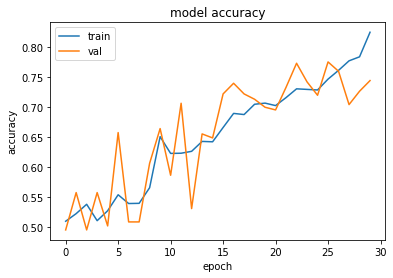

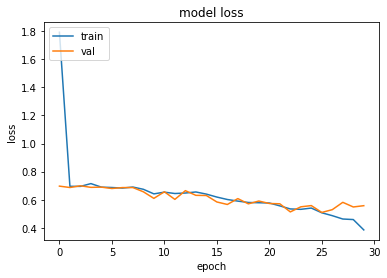

Folder num 2
Genre split [['Rock', 'Pop'], ['Folk', 'Instrumental']]
Building model...
Training...
Epoch 1/30
50/50 [==============================] - 7s 126ms/step - loss: 1.2709 - accuracy: 0.5094 - val_loss: 0.6746 - val_accuracy: 0.5933

Epoch 00001: val_accuracy improved from -inf to 0.59333, saving model to ./models/model_root_f1/folder2\model.h5
Epoch 2/30
50/50 [==============================] - 6s 116ms/step - loss: 0.6246 - accuracy: 0.6516 - val_loss: 0.6113 - val_accuracy: 0.6222

Epoch 00002: val_accuracy improved from 0.59333 to 0.62222, saving model to ./models/model_root_f1/folder2\model.h5
Epoch 3/30
50/50 [==============================] - 6s 117ms/step - loss: 0.5805 - accuracy: 0.7196 - val_loss: 0.5278 - val_accuracy: 0.7711

Epoch 00003: val_accuracy improved from 0.62222 to 0.77111, saving model to ./models/model_root_f1/folder2\model.h5
Epoch 4/30
50/50 [==============================] - 6s 116ms/step - loss: 0.5331 - accuracy: 0.7421 - val_loss: 0.5079 - val_ac

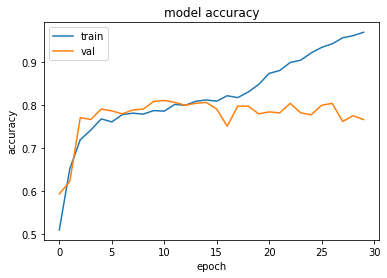

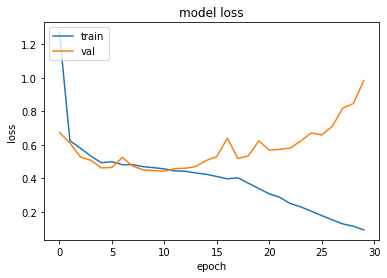

Folder num 3
Genre split [['Instrumental', 'Folk'], ['Rock', 'Pop']]
Building model...
Training...
Epoch 1/30
50/50 [==============================] - 7s 123ms/step - loss: 1.5348 - accuracy: 0.5529 - val_loss: 0.6604 - val_accuracy: 0.5489

Epoch 00001: val_accuracy improved from -inf to 0.54889, saving model to ./models/model_root_f1/folder3\model.h5
Epoch 2/30
50/50 [==============================] - 6s 116ms/step - loss: 0.6014 - accuracy: 0.6780 - val_loss: 0.5686 - val_accuracy: 0.7200

Epoch 00002: val_accuracy improved from 0.54889 to 0.72000, saving model to ./models/model_root_f1/folder3\model.h5
Epoch 3/30
50/50 [==============================] - 6s 117ms/step - loss: 0.5303 - accuracy: 0.7482 - val_loss: 0.4986 - val_accuracy: 0.7467

Epoch 00003: val_accuracy improved from 0.72000 to 0.74667, saving model to ./models/model_root_f1/folder3\model.h5
Epoch 4/30
50/50 [==============================] - 6s 117ms/step - loss: 0.5039 - accuracy: 0.7615 - val_loss: 0.4689 - val_ac

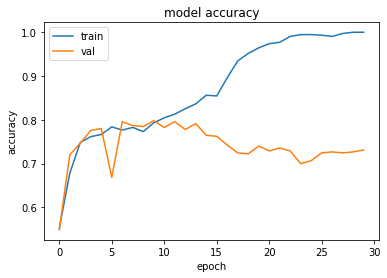

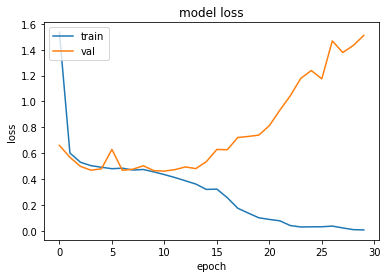

Folder num 4
Genre split [['Pop', 'Rock'], ['Instrumental', 'Folk']]
Building model...
Training...
Epoch 1/30
50/50 [==============================] - 7s 124ms/step - loss: 1.4701 - accuracy: 0.5243 - val_loss: 0.6639 - val_accuracy: 0.6622

Epoch 00001: val_accuracy improved from -inf to 0.66222, saving model to ./models/model_root_f1/folder4\model.h5
Epoch 2/30
50/50 [==============================] - 6s 116ms/step - loss: 0.6531 - accuracy: 0.5989 - val_loss: 0.6947 - val_accuracy: 0.5022

Epoch 00002: val_accuracy did not improve from 0.66222
Epoch 3/30
50/50 [==============================] - 6s 116ms/step - loss: 0.5987 - accuracy: 0.6783 - val_loss: 0.5670 - val_accuracy: 0.7022

Epoch 00003: val_accuracy improved from 0.66222 to 0.70222, saving model to ./models/model_root_f1/folder4\model.h5
Epoch 4/30
50/50 [==============================] - 6s 119ms/step - loss: 0.5590 - accuracy: 0.7171 - val_loss: 0.5070 - val_accuracy: 0.7689

Epoch 00004: val_accuracy improved from 0.702

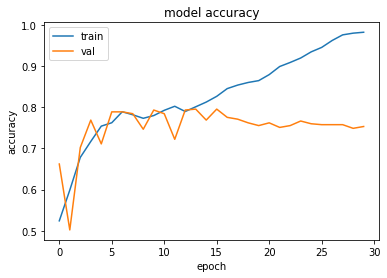

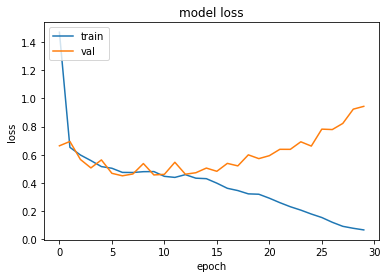

Folder num 5
Genre split [['Instrumental', 'Rock'], ['Pop', 'Folk']]
Building model...
Training...
Epoch 1/30
50/50 [==============================] - 7s 123ms/step - loss: 1.7120 - accuracy: 0.5094 - val_loss: 0.6931 - val_accuracy: 0.4822

Epoch 00001: val_accuracy improved from -inf to 0.48222, saving model to ./models/model_root_f1/folder5\model.h5
Epoch 2/30
50/50 [==============================] - 6s 117ms/step - loss: 0.6834 - accuracy: 0.5691 - val_loss: 0.7164 - val_accuracy: 0.5244

Epoch 00002: val_accuracy improved from 0.48222 to 0.52444, saving model to ./models/model_root_f1/folder5\model.h5
Epoch 3/30
50/50 [==============================] - 6s 117ms/step - loss: 0.6712 - accuracy: 0.5897 - val_loss: 0.6356 - val_accuracy: 0.6644

Epoch 00003: val_accuracy improved from 0.52444 to 0.66444, saving model to ./models/model_root_f1/folder5\model.h5
Epoch 4/30
50/50 [==============================] - 6s 117ms/step - loss: 0.6390 - accuracy: 0.6418 - val_loss: 0.6216 - val_ac

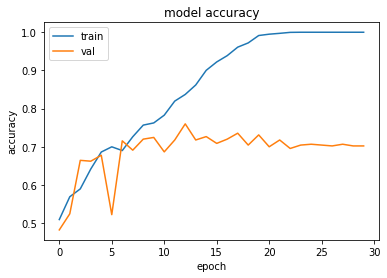

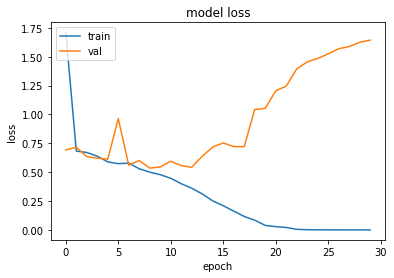

Folder num 6
Genre split [['Folk', 'Instrumental'], ['Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
50/50 [==============================] - 6s 122ms/step - loss: 1.6943 - accuracy: 0.5624 - val_loss: 0.6260 - val_accuracy: 0.6067

Epoch 00001: val_accuracy improved from -inf to 0.60667, saving model to ./models/model_root_f1/folder6\model.h5
Epoch 2/30
50/50 [==============================] - 6s 117ms/step - loss: 0.6038 - accuracy: 0.6824 - val_loss: 0.5266 - val_accuracy: 0.7422

Epoch 00002: val_accuracy improved from 0.60667 to 0.74222, saving model to ./models/model_root_f1/folder6\model.h5
Epoch 3/30
50/50 [==============================] - 6s 118ms/step - loss: 0.5715 - accuracy: 0.7072 - val_loss: 0.5429 - val_accuracy: 0.7267

Epoch 00003: val_accuracy did not improve from 0.74222
Epoch 4/30
50/50 [==============================] - 6s 117ms/step - loss: 0.5154 - accuracy: 0.7485 - val_loss: 0.5433 - val_accuracy: 0.7422

Epoch 00004: val_accuracy did not improve fro

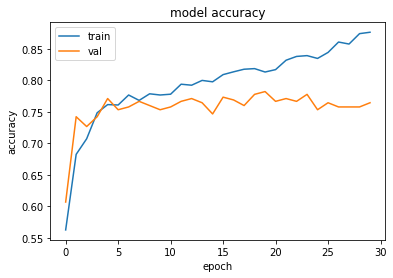

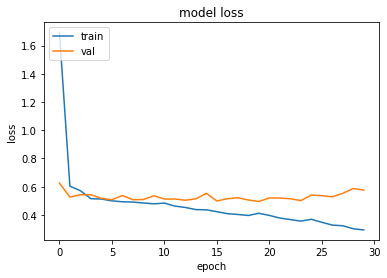

Folder num 7
Genre split [['Instrumental', 'Folk'], ['Rock', 'Pop']]
Building model...
Training...
Epoch 1/30
50/50 [==============================] - 7s 123ms/step - loss: 1.1818 - accuracy: 0.5869 - val_loss: 0.7020 - val_accuracy: 0.5333

Epoch 00001: val_accuracy improved from -inf to 0.53333, saving model to ./models/model_root_f1/folder7\model.h5
Epoch 2/30
50/50 [==============================] - 6s 116ms/step - loss: 0.5708 - accuracy: 0.7066 - val_loss: 0.4910 - val_accuracy: 0.8000

Epoch 00002: val_accuracy improved from 0.53333 to 0.80000, saving model to ./models/model_root_f1/folder7\model.h5
Epoch 3/30
50/50 [==============================] - 6s 117ms/step - loss: 0.5199 - accuracy: 0.7533 - val_loss: 0.5139 - val_accuracy: 0.7511

Epoch 00003: val_accuracy did not improve from 0.80000
Epoch 4/30
50/50 [==============================] - 6s 117ms/step - loss: 0.4927 - accuracy: 0.7726 - val_loss: 0.5361 - val_accuracy: 0.7444

Epoch 00004: val_accuracy did not improve fro

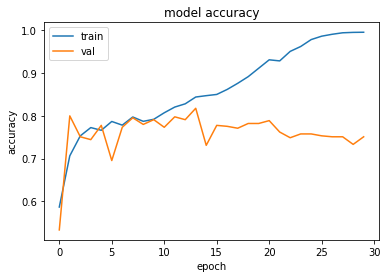

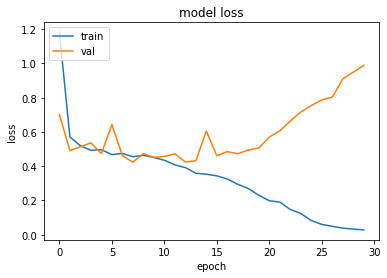

Folder num 8
Genre split [['Rock', 'Pop'], ['Folk', 'Instrumental']]
Building model...
Training...
Epoch 1/30
50/50 [==============================] - 7s 138ms/step - loss: 1.4500 - accuracy: 0.5225 - val_loss: 0.6601 - val_accuracy: 0.5234

Epoch 00001: val_accuracy improved from -inf to 0.52339, saving model to ./models/model_root_f1/folder8\model.h5
Epoch 2/30
50/50 [==============================] - 6s 117ms/step - loss: 0.6192 - accuracy: 0.6775 - val_loss: 0.6148 - val_accuracy: 0.6526

Epoch 00002: val_accuracy improved from 0.52339 to 0.65256, saving model to ./models/model_root_f1/folder8\model.h5
Epoch 3/30
50/50 [==============================] - 6s 116ms/step - loss: 0.5461 - accuracy: 0.7225 - val_loss: 0.5369 - val_accuracy: 0.7394

Epoch 00003: val_accuracy improved from 0.65256 to 0.73942, saving model to ./models/model_root_f1/folder8\model.h5
Epoch 4/30
50/50 [==============================] - 6s 116ms/step - loss: 0.5601 - accuracy: 0.7137 - val_loss: 0.5528 - val_ac

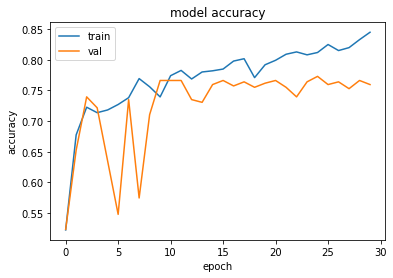

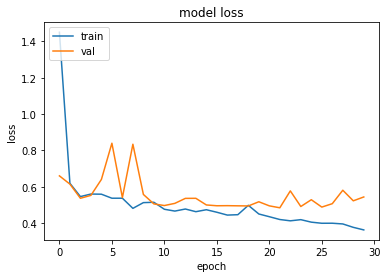

In [23]:
X_train_cross = np.concatenate((X_train, X_valid), axis=0)
y_train_cross = np.concatenate((y_train, y_valid), axis=0)

num_splits = 8

kfold = KFold(n_splits=8, shuffle=True)
genre_splits = create_split(list(dict_genres.values()), num_splits)

fold_no = 1
for train, test in kfold.split(X_train_cross, y_train_cross):
    split = genre_splits[fold_no - 1]
    
    y_train_cross_binary = np.argmax(y_train_cross, axis=1)
    y_train_cross_binary = np.in1d(y_train_cross_binary, split[0])
    y_train_cross_binary = utils.to_categorical(y_train_cross_binary*1, num_classes=2)

    print("Folder num {}".format(fold_no))
    genres_name = [[reverse_map[g] for g in split_l] for split_l in split]
    print("Genre split {}".format(genres_name))
    
    model, history  = train_model(X_train_cross[train], y_train_cross_binary[train], X_train_cross[test], y_train_cross_binary[test], "folder{}".format(fold_no), genres_name)
    show_summary_stats(history)
    
    fold_no += 1
    if fold_no > num_splits:
        break